In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import utils as utl
import scipy as sc
from collections import OrderedDict
# importing NN library
import torch as tr
import torch.nn as nn
# importing torch distributions and transformations 
import torch.distributions as trd
import torch.distributions.transforms as trt
from models import ConditionalModel, QuantileRegressionModel
from sklearn import preprocessing

In [3]:
#Reading data
df_trn = pd.read_csv('Predictive_Expenses_DATA/train.csv')
df_tst = pd.read_csv('Predictive_Expenses_DATA/test.csv')

# Preprocess the data
df_trn = utl.preProcess(df_trn)
df_tst = utl.preProcess(df_tst)

# Keeping only positive portion of the data
df_trn = df_trn.loc[df_trn['expense']>1]


In [4]:
# Further splittling the training dataset into training and validation
# first, shuffling training dataset before splitting (sample with fraction =1 shuffles all the rows)
np.random.seed(0)
df_trn=df_trn.sample(frac=1)
n_trn = int(len(df_trn)*0.75)
# then, splitting
df_vld=df_trn.iloc[n_trn:]
df_trn=df_trn.iloc[:n_trn]

print(f' Train Data Size: {len(df_trn)}, Validation Data Size: {len(df_vld)} Test Data Size: {len(df_tst)}')

 Train Data Size: 538290, Validation Data Size: 179431 Test Data Size: 185469


In [5]:
# Specifying the target and covariates for regression
target = 'log_expense'
covariates=df_trn.columns.to_list()
to_remove=['id','wi','income','expense','wts','log_expense']
covariates = [var for var in covariates if var not in to_remove]
print(f'\033[1m Covariates:\033[0m {covariates}')
print(f'\033[1m Target: \033[0m{target}')

 Covariates: ['year', 'month', 'age', 'education', 'familysize', 'urban', 'race', 'region', 'state', 'marital', 'occupation', 'log_income']
 Target: log_expense


 Covariates: ['age', 'education', 'familysize', 'marital', 'occupation', 'log_income']


C:\Users\tewar\Anaconda3\envs\pythonEnvPyTorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


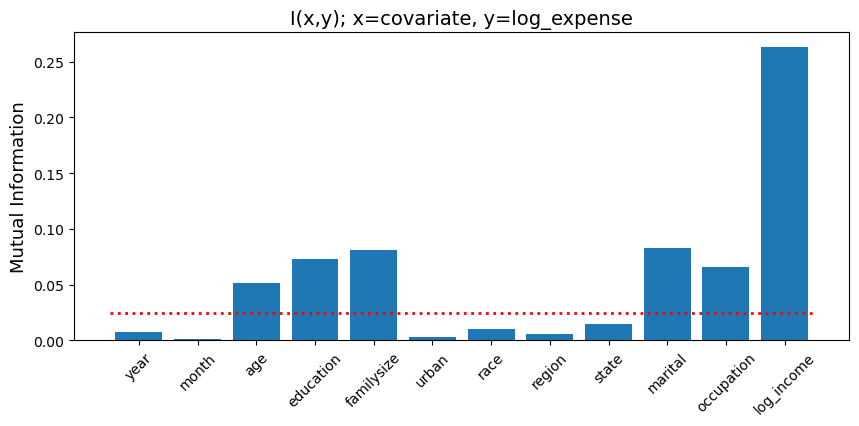

In [6]:
# Assessing Information Content (about the target) of the covariates via Mutual infromation (MI)
mutual_info={}
y = utl.discretize(df_trn[target],20) # target variable (discretizing it for MI calculation)
for var in covariates:
    x=df_trn[var].to_numpy()
    x=utl.discretize(x,20)
    mutual_info[var]=mutual_info_score(x,y)
    
MI_threshold=0.025 # Thrshold for mutual Information
# plotting MI
plt.figure(figsize=(10,4))
plt.bar(list(mutual_info.keys()), list(mutual_info.values()));
plt.plot(np.arange(-1,len(covariates))+0.5,np.array([MI_threshold]*(len(covariates)+1)),'r:',linewidth=2)
ax=plt.gca();
ax.set_xticklabels(list(mutual_info.keys()), rotation = 45);
plt.ylabel('Mutual Information',fontsize=13)
plt.title('I(x,y); x=covariate, y=log_expense',fontsize=14)

# Keeping only those covariate with MI above the specified threshold
covariates=[var for var in covariates if mutual_info[var]>MI_threshold]
print(f'\033[1m Covariates:\033[0m {covariates}')


In [7]:
# Defining the Covariate Type (Categorical, Numeric). Ordinal Variable (eduction) is considered Numeric here.
covariates_categorical = ['marital','occupation']
covariates_numeric = [var for var in covariates if var not in covariates_categorical]
print(f'\033[1m Categorical Covariates: \033[0m {covariates_categorical}')
print(f'\033[1m Numerical Covariates: \033[0m {covariates_numeric}')

 Categorical Covariates:  ['marital', 'occupation']
 Numerical Covariates:  ['age', 'education', 'familysize', 'log_income']


In [8]:
# Standardizing Numerical covariates
standard_transforms={}
for var in covariates_numeric+[target]:
    # estimate loc and scale w.r.t to training dataset
    standardize = preprocessing.StandardScaler().fit(df_trn[var].to_numpy().reshape(-1,1))
    df_trn[var]=standardize.transform(df_trn[var].to_numpy().reshape(-1,1))
    # also standardize the validation and test datasets
    df_vld[var]=standardize.transform(df_vld[var].to_numpy().reshape(-1,1))
    if var in df_tst:
        df_tst[var]=standardize.transform(df_tst[var].to_numpy().reshape(-1,1))
    standard_transforms[var]=standardize

In [9]:
# Hot encoding the categorical variables for all datasets 
df_trn_categorical, new_covariates_categorical=utl.hotEncodeData(df_trn,covariates_categorical)
df_vld_categorical,_=utl.hotEncodeData(df_vld,covariates_categorical)
df_tst_categorical,_=utl.hotEncodeData(df_tst,covariates_categorical)

# Joing the categorical tables into the original tables
df_trn = pd.concat([df_trn,df_trn_categorical],ignore_index=False,axis=1)
df_vld = pd.concat([df_vld,df_vld_categorical],ignore_index=False,axis=1)
df_tst = pd.concat([df_tst,df_tst_categorical],ignore_index=False,axis=1)
# freeing up memory
del df_trn_categorical, df_vld_categorical, df_tst_categorical

In [10]:
# collecting all covariate names
covariates=new_covariates_categorical+covariates_numeric

In [11]:
# Defining train step
def train_step(row_ids, q, loss_type):
    exp_model.train()
    X_batch, y_batch, w_batch = utl.getBatch(df_trn, 
                                    row_ids, 
                                    covariates,
                                    target)
            
    X_batch, y_batch, w_batch = map(tr.FloatTensor,(X_batch,y_batch, w_batch))        
    mu,log_sig=exp_model.forward(X_batch)
    y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))
    if loss_type=='MLE':
        return utl.MLE_loss(y_dist, y_batch, w_batch)
    else:
        Q_batch=y_dist.icdf(tr.FloatTensor(q))
        return utl.pinballLoss(Q_batch, q, y_batch, w_batch)  

# Defining validation step
def valid_step(row_ids, q, loss_type):
    exp_model.eval()
    X_batch, y_batch, w_batch = utl.getBatch(df_vld, 
                                    row_ids, 
                                    covariates,
                                    target)
    X_batch, y_batch, w_batch = map(tr.FloatTensor,(X_batch,y_batch, w_batch))
    with tr.no_grad(): 
        mu,log_sig=exp_model.forward(X_batch)
    y_dist=trd.Normal(loc=mu.view(-1,1),scale=tr.exp(log_sig.view(-1,1)))
    if loss_type=='MLE':
        return utl.MLE_loss(y_dist, y_batch, w_batch)
    else:
        Q_batch=y_dist.icdf(tr.FloatTensor(q))
        return utl.pinballLoss(Q_batch, q, y_batch, w_batch)       

# Defining t
def fit(quantiles_at, epochs=10, batch_size_train=100, batch_size_valid=500, loss_type='MLE',print_every=100):
    n_train = len(df_trn)
    n_valid = len(df_vld)
    n_iters = n_train//batch_size_train+1
    loss_train,loss_valid=[],[]
          
    for epoch in range(epochs): 
        # reshuffling trainig data at every epoch
        trn_indices=df_trn.index.to_list()
        np.random.shuffle(trn_indices)
        # Training 
        for itr in range(n_iters):
            st,en=itr*batch_size_train, min(n_train,(itr+1)*batch_size_train)
            row_ids = trn_indices[st:en]         
            trn_loss = train_step(row_ids, quantiles_at, loss_type)          
            trn_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if itr%print_every==0:
                # Validation Step
                vld_indices=df_vld.index.to_list()
                row_ids = np.random.choice(vld_indices,batch_size_valid,replace=False).tolist()
                vld_loss = valid_step(row_ids, quantiles_at, loss_type)
#                 # rounding losses               
                trn_loss=np.round(float(trn_loss.data),2)
                vld_loss=np.round(float(vld_loss.data),2)
                
                
                print(f'Epoch: {epoch}, Iter: {itr}, Train Loss: {trn_loss}, Valid Loss: {vld_loss}')
                loss_train.append(trn_loss)
                loss_valid.append(vld_loss)
    return loss_train, loss_valid

In [16]:
# Instantiating the DNN based conditional density model for the target i.e. p(y|X)
input_dim = len(covariates)
quantiles_at = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
layers = [input_dim, input_dim]
exp_model=ConditionalModel(input_dim,layers)
optimizer = tr.optim.Adam(exp_model.parameters(),lr=1E-4)
# fitting the model
loss_train, loss_valid=fit(quantiles_at, 
                           batch_size_train=200, 
                           batch_size_valid=1000, 
                           epochs=10,
                           loss_type='MLE')

Epoch: 0, Iter: 0, Train Loss: 4853.58, Valid Loss: 2575.47
Epoch: 0, Iter: 100, Train Loss: 2707.21, Valid Loss: 2624.45
Epoch: 0, Iter: 200, Train Loss: 2204.48, Valid Loss: 2392.67
Epoch: 0, Iter: 300, Train Loss: 2157.19, Valid Loss: 2299.52
Epoch: 0, Iter: 400, Train Loss: 2201.79, Valid Loss: 2165.65
Epoch: 0, Iter: 500, Train Loss: 2089.99, Valid Loss: 1991.22
Epoch: 0, Iter: 600, Train Loss: 1935.36, Valid Loss: 2019.8
Epoch: 0, Iter: 700, Train Loss: 1897.81, Valid Loss: 2100.08
Epoch: 0, Iter: 800, Train Loss: 1963.16, Valid Loss: 2025.09
Epoch: 0, Iter: 900, Train Loss: 2006.97, Valid Loss: 1929.39
Epoch: 0, Iter: 1000, Train Loss: 1858.48, Valid Loss: 1961.15
Epoch: 0, Iter: 1100, Train Loss: 1834.61, Valid Loss: 1898.46
Epoch: 0, Iter: 1200, Train Loss: 1807.06, Valid Loss: 1896.08
Epoch: 0, Iter: 1300, Train Loss: 1862.12, Valid Loss: 1999.29
Epoch: 0, Iter: 1400, Train Loss: 2076.41, Valid Loss: 1974.26
Epoch: 0, Iter: 1500, Train Loss: 2058.65, Valid Loss: 1872.56
Epoch

Epoch: 4, Iter: 2400, Train Loss: 1824.71, Valid Loss: 1815.94
Epoch: 4, Iter: 2500, Train Loss: 1943.76, Valid Loss: 1836.9
Epoch: 4, Iter: 2600, Train Loss: 1679.74, Valid Loss: 1906.9
Epoch: 5, Iter: 0, Train Loss: 1903.62, Valid Loss: 1905.92
Epoch: 5, Iter: 100, Train Loss: 1680.03, Valid Loss: 1879.54
Epoch: 5, Iter: 200, Train Loss: 2186.0, Valid Loss: 1893.07
Epoch: 5, Iter: 300, Train Loss: 1844.86, Valid Loss: 1863.3
Epoch: 5, Iter: 400, Train Loss: 1883.44, Valid Loss: 2002.76
Epoch: 5, Iter: 500, Train Loss: 1652.04, Valid Loss: 1929.54
Epoch: 5, Iter: 600, Train Loss: 1701.67, Valid Loss: 2042.04
Epoch: 5, Iter: 700, Train Loss: 2004.92, Valid Loss: 1959.59
Epoch: 5, Iter: 800, Train Loss: 1762.11, Valid Loss: 1780.54
Epoch: 5, Iter: 900, Train Loss: 2046.43, Valid Loss: 1895.8
Epoch: 5, Iter: 1000, Train Loss: 1925.22, Valid Loss: 1776.31
Epoch: 5, Iter: 1100, Train Loss: 1933.92, Valid Loss: 1991.83
Epoch: 5, Iter: 1200, Train Loss: 1666.95, Valid Loss: 1912.28
Epoch: 5,

Epoch: 9, Iter: 2100, Train Loss: 1820.71, Valid Loss: 1871.85
Epoch: 9, Iter: 2200, Train Loss: 1811.72, Valid Loss: 1871.67
Epoch: 9, Iter: 2300, Train Loss: 1733.12, Valid Loss: 1786.03
Epoch: 9, Iter: 2400, Train Loss: 1895.9, Valid Loss: 1965.69
Epoch: 9, Iter: 2500, Train Loss: 1723.51, Valid Loss: 1933.01
Epoch: 9, Iter: 2600, Train Loss: 1726.49, Valid Loss: 1861.86


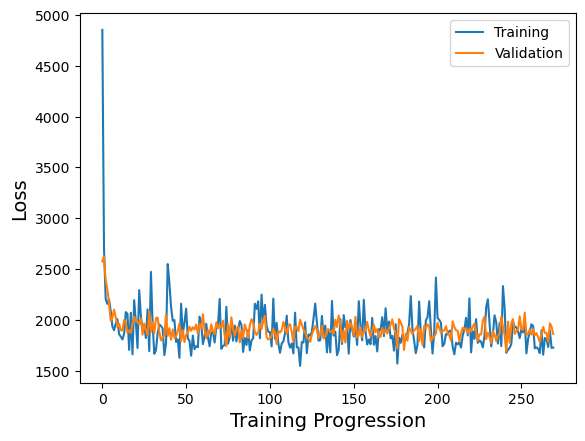

In [18]:
# Plotting Losses
plt.plot(loss_train)
plt.plot(loss_valid)
plt.xlabel('Training Progression',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(['Training','Validation'])

In [20]:
# Saving model
filename='ConditionalGaussian_MLE_loss'
tr.save(exp_model.state_dict(), 'saved_models/'+filename)
